In [1]:
pip install ultralytics

  Using cached ultralytics-8.3.117-py3-none-any.whl.metadata (37 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
Using cached ultralytics-8.3.117-py3-none-any.whl (984 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   --------

In [1]:
import cv2
from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')

cap = cv2.VideoCapture(0)  #open webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO pose prediction WITHOUT showing
    results = model.predict(frame, conf=0.5, stream=True)

    for r in results:
        # Get the annotated frame from results
        annotated_frame = r.plot()

        # Show using OpenCV
        cv2.imshow('YOLOv8 Pose Detection', annotated_frame)

    # Exit when pressing 'f'
    if cv2.waitKey(1) & 0xFF == ord('f'):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 115.5ms
Speed: 3.9ms preprocess, 115.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 136.3ms
Speed: 3.6ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 155.7ms
Speed: 4.5ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 126.4ms
Speed: 2.5ms preprocess, 126.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 130.4ms
Speed: 2.4ms preprocess, 130.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 166.7ms
Speed: 3.0ms preprocess, 166.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 140.6ms
Speed: 3.5ms preprocess, 140.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 150.0ms
Speed: 3.1ms prepr

In [3]:
from ultralytics import YOLO
import cv2
import os
import pandas as pd

# Load YOLOv8-pose model
model = YOLO('yolov8n-pose.pt')


data_root = r'C:/Users/Kassimi/OneDrive/Bureau/cv_data/squat/'
folders = ['correct_form', 'wrong_form']

# Output CSV data
output_data = []

for label in folders:
    folder_path = os.path.join(data_root, label)

    for video_file in os.listdir(folder_path):
        if not video_file.endswith(('.mp4', '.avi', '.mov')):
            continue

        video_path = os.path.join(folder_path, video_file)
        cap = cv2.VideoCapture(video_path)
        frame_index = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Pose estimation
            results = model.predict(frame, save=False, verbose=False)
            keypoints = results[0].keypoints.xy.cpu().numpy()  # shape: (n_person, 17, 2)

            if len(keypoints) == 0:
                frame_index += 1
                continue  # No person detected in frame

            # Take only the first person detected
            person_keypoints = keypoints[0].flatten()  # shape: (34,)

            # Store with metadata
            row = [video_file, frame_index] + list(person_keypoints) + [label]
            output_data.append(row)

            frame_index += 1

        cap.release()

# Define column names
columns = ['video_id', 'frame'] + [f'kp_{i}_{coord}' for i in range(17) for coord in ['x', 'y']] + ['label']
df = pd.DataFrame(output_data, columns=columns)

# Save to CSV
output_csv_path = os.path.join(data_root, 'squat_pose_data.csv')
df.to_csv(output_csv_path, index=False)

print(f"✅ Sequential keypoints saved to: {output_csv_path}")


✅ Sequential keypoints saved to: C:/Users/Kassimi/OneDrive/Bureau/cv_data/squat/squat_pose_data.csv


In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load the CSV data
df = pd.read_csv(r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\squat_pose_data.csv")

# Features (keypoints) and labels
X = df.drop(columns=['label'])  # All columns except label are keypoints
y = df['label'].map({'correct': 1, 'wrong': 0})  # Convert labels to 1 (correct) or 0 (wrong)

# Normalize keypoints using StandardScaler (so all values are on a similar scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Train-test split (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create a PyTorch dataset for easier batching
class SquatDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoader objects for batching
train_dataset = SquatDataset(X_train, y_train)
val_dataset = SquatDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


ValueError: could not convert string to float: 'correct_1.mp4'

In [9]:
class SquatNet(nn.Module):
    def __init__(self):
        super(SquatNet, self).__init__()
        self.fc1 = nn.Linear(34, 64)  # Input layer to hidden layer
        self.fc2 = nn.Linear(64, 32)  # Hidden layer
        self.fc3 = nn.Linear(32, 2)   # Output layer (correct or wrong)
        self.relu = nn.ReLU()         # Activation function
        self.softmax = nn.Softmax(dim=1)  # Softmax for output probabilities
    
    def forward(self, x):
        x = self.relu(self.fc1(x))  # First hidden layer
        x = self.relu(self.fc2(x))  # Second hidden layer
        x = self.fc3(x)             # Output layer
        return self.softmax(x)      # Softmax activation for probabilities

# Initialize the model
model = SquatNet()


In [13]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Used for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()   # Clear the gradients
        outputs = model(inputs) # Get predictions from the model

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update model weights
        
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():  # No gradient calculation during evaluation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_preds / total_preds

    # Print training and validation results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")


NameError: name 'train_loader' is not defined

In [13]:
# Save the model
torch.save(model.state_dict(), r'C:\Users\Kassimi\OneDrive\Bureau\cv_data\squatsquat_model.pth')
print("Model saved!")


Model saved!


In [3]:
pip install --upgrade pytube


Note: you may need to restart the kernel to use updated packages.


now to making a prediction on a new video

In [ ]:
# Load the trained model
model = SquatNet()
model.load_state_dict(torch.load(r'C:\Users\Kassimi\OneDrive\Bureau\cv_data\squatsquat_model.pth'))
model.eval()

# Load the scaler you used before
scaler = StandardScaler()
df = pd.read_csv(r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\squat_pose_data.csv")
X = df.drop(columns=['label'])
scaler.fit(X)  # fit on original data to re-use for new data

# Load YOLO pose model again
yolo_model = YOLO('yolov8n-pose.pt')

# New video path
new_video_path = r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\correct_form\correct_11.mp4"
cap = cv2.VideoCapture(new_video_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Pose estimation
    results = yolo_model.predict(frame, save=False, verbose=False)
    keypoints = results[0].keypoints.xy.cpu().numpy()

    if len(keypoints) == 0:
        continue  # No person detected

    # Only first person
    person_keypoints = keypoints[0].flatten()

    if len(person_keypoints) != 34:  # 17 keypoints * 2 (x,y)
        continue  # Safety check

    # Scale keypoints
    person_keypoints_scaled = scaler.transform([person_keypoints])

    # Convert to tensor
    input_tensor = torch.tensor(person_keypoints_scaled, dtype=torch.float32)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)

    # Map prediction
    label = 'Correct' if predicted_class.item() == 1 else 'Wrong'

    # Display result on frame
    cv2.putText(frame, label, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0) if label == 'Correct' else (0, 0, 255), 3)

    # Show frame
    cv2.imshow('Squat Form Prediction', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [15]:
import torch
import pandas as pd
import cv2
from sklearn.preprocessing import StandardScaler
from ultralytics import YOLO

# Define SquatNet again
class SquatNet(torch.nn.Module):
    def __init__(self):
        super(SquatNet, self).__init__()
        self.fc1 = torch.nn.Linear(34, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Load the trained model
model = SquatNet()
model.load_state_dict(torch.load(r'C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat_model.pth'))
model.eval()


scaler = StandardScaler()
df = pd.read_csv(r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\squat_pose_data.csv")
X = df.drop(columns=['label'])
scaler.fit(X)

# Load YOLOv8 pose model
yolo_model = YOLO('yolov8n-pose.pt')


cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Cannot open webcam")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Can't receive frame. Exiting...")
        break

    # Pose estimation
    results = yolo_model.predict(frame, save=False, verbose=False)
    keypoints = results[0].keypoints.xy.cpu().numpy()

    if len(keypoints) > 0:
        # Only first detected person
        person_keypoints = keypoints[0].flatten()

        if len(person_keypoints) == 34:  # 17 keypoints * 2 (x, y)
            # Scale keypoints
            person_keypoints_scaled = scaler.transform([person_keypoints])

            # Convert to tensor
            input_tensor = torch.tensor(person_keypoints_scaled, dtype=torch.float32)

            # Predict
            with torch.no_grad():
                output = model(input_tensor)
                _, predicted_class = torch.max(output, 1)

            # Map prediction
            label = 'Correct' if predicted_class.item() == 1 else 'Wrong'

            # Display result on frame
            color = (0, 255, 0) if label == 'Correct' else (0, 0, 255)
            cv2.putText(frame, label, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    # Show frame
    cv2.imshow('Live Squat Form Prediction', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Kassimi\\OneDrive\\Bureau\\cv_data\\squat_model.pth'

In [17]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
# Load CSV
df = pd.read_csv(r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\squat_pose_data.csv")

# Convert label to numeric
df['label'] = df['label'].map({'correct_form': 1, 'wrong_form': 0})

# Parameters
sequence_length = 30  # Choose fixed sequence length
min_frames_required = sequence_length

# Normalize keypoints
keypoint_cols = [col for col in df.columns if col.startswith('kp_')]
scaler = StandardScaler()
df[keypoint_cols] = scaler.fit_transform(df[keypoint_cols])

# Group by video and build sequences
X_sequences = []
y_labels = []

for video_id, group in df.groupby('video_id'):
    group = group.sort_values('frame')
    keypoints = group[keypoint_cols].values  # shape: (num_frames, 34)
    label = group['label'].iloc[0]

    # Skip short sequences
    if len(keypoints) < min_frames_required:
        continue

    # Break long videos into multiple sequences
    for start in range(0, len(keypoints) - sequence_length + 1, sequence_length):
        seq = keypoints[start:start + sequence_length]
        X_sequences.append(seq)
        y_labels.append(label)

# Convert to tensors


X_tensor = torch.tensor(np.array(X_sequences), dtype=torch.float32)
 # shape: (N, seq_len, 34)
y_tensor = torch.tensor(y_labels, dtype=torch.long)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# PyTorch Dataset
class SquatSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataloaders
train_dataset = SquatSequenceDataset(X_train, y_train)
val_dataset = SquatSequenceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class SquatNetLSTM(nn.Module):
    def __init__(self):
        super(SquatNetLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=34, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(64, 64)  # LSTM output to hidden layer
        self.fc2 = nn.Linear(64, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, 34)
        lstm_out, _ = self.lstm(x)              # Output shape: (batch_size, sequence_length, hidden_size)
        x = lstm_out[:, -1, :]                  # Take output from the last time step
        x = self.relu(self.fc1(x))              # Pass through FC layer
        x = self.fc2(x)                         # Output layer
        return self.sigmoid(x)                  # Softmax for probabilities


In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SquatNetLSTM().to(device)

# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()  # This combines sigmoid and binary cross-entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Ensure labels are of shape (batch_size,)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

    avg_train_loss = train_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            val_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

    avg_val_loss = val_loss / total
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/100] Train Loss: 0.5401, Train Acc: 0.8172 | Val Loss: 0.4424, Val Acc: 0.8333
Epoch [2/100] Train Loss: 0.4361, Train Acc: 0.8172 | Val Loss: 0.4065, Val Acc: 0.8333
Epoch [3/100] Train Loss: 0.4326, Train Acc: 0.8172 | Val Loss: 0.3929, Val Acc: 0.8333
Epoch [4/100] Train Loss: 0.4117, Train Acc: 0.8172 | Val Loss: 0.3767, Val Acc: 0.8333
Epoch [5/100] Train Loss: 0.4094, Train Acc: 0.8172 | Val Loss: 0.3767, Val Acc: 0.8333
Epoch [6/100] Train Loss: 0.4028, Train Acc: 0.8172 | Val Loss: 0.3769, Val Acc: 0.8333
Epoch [7/100] Train Loss: 0.4028, Train Acc: 0.8172 | Val Loss: 0.3774, Val Acc: 0.8333
Epoch [8/100] Train Loss: 0.4094, Train Acc: 0.8172 | Val Loss: 0.3811, Val Acc: 0.8333
Epoch [9/100] Train Loss: 0.4094, Train Acc: 0.8172 | Val Loss: 0.4055, Val Acc: 0.8333
Epoch [10/100] Train Loss: 0.4134, Train Acc: 0.8710 | Val Loss: 0.3847, Val Acc: 0.9167
Epoch [11/100] Train Loss: 0.4094, Train Acc: 0.8925 | Val Loss: 0.3876, Val Acc: 0.9167
Epoch [12/100] Train Loss: 0.4

In [23]:
# Save the trained model
model_path = r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat_lstm_model.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")


✅ Model saved to C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat_lstm_model.pth


In [25]:
import torch
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
from sklearn.preprocessing import StandardScaler
from collections import deque

# LSTM sequence length
sequence_length = 30

# Load trained model
model = SquatNetLSTM()
model.load_state_dict(torch.load(r'C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat_lstm_model.pth'))
model.eval()

# Load scaler (refit on original dataset)
df = pd.read_csv(r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\squat_pose_data.csv")
keypoint_cols = [col for col in df.columns if col.startswith('kp_')]
scaler = StandardScaler()
scaler.fit(df[keypoint_cols])  # Fit only on keypoints

# Load YOLO pose model
yolo_model = YOLO('yolov8n-pose.pt')

# Video path
video_path = r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\preprocessed\wrong\wrong_4_augmented_6.mp4"
cap = cv2.VideoCapture(video_path)

# Buffer to store sequence of keypoints
sequence_buffer = deque(maxlen=sequence_length)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = yolo_model.predict(frame, save=False, verbose=False)
    keypoints = results[0].keypoints.xy.cpu().numpy()

    if len(keypoints) == 0:
        continue

    person_keypoints = keypoints[0].flatten()

    if len(person_keypoints) != 34:
        continue

    # Scale keypoints
    person_keypoints_scaled = scaler.transform([person_keypoints])[0]
    sequence_buffer.append(person_keypoints_scaled)

    # Only predict when we have a full sequence
    if len(sequence_buffer) == sequence_length:
        input_seq = torch.tensor([list(sequence_buffer)], dtype=torch.float32)  # Shape: (1, seq_len, 34)

        with torch.no_grad():
            output = model(input_seq)
            _, predicted_class = torch.max(output, 1)

        label = 'Correct' if predicted_class.item() == 1 else 'Wrong'
        color = (0, 255, 0) if label == 'Correct' else (0, 0, 255)

        cv2.putText(frame, label, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    cv2.imshow('Squat Form Prediction', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Kassimi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Kassimi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Kassimi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Kassimi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Kassimi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Kassimi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not 

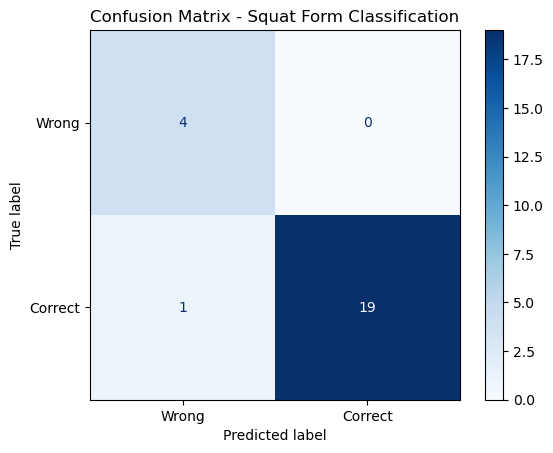

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Set model to eval mode
model.eval()

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wrong', 'Correct'])

# Plot
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Squat Form Classification")
plt.show()


In [30]:
import pandas as pd

# Load the CSV with keypoints and video data
df = pd.read_csv(r"C:\Users\Kassimi\OneDrive\Bureau\cv_data\squat\squat_pose_data.csv")

# Count number of frames for each video
frame_counts = df.groupby('video_id').size()

# Print the number of frames per video
print("Number of frames per video:")
print(frame_counts)

Number of frames per video:
video_id
correct_1.mp4     173
correct_10.mp4    782
correct_11.mp4    146
correct_12.mp4    173
correct_2.mp4     244
correct_3.mp4     391
correct_5.mp4      53
correct_6.mp4     373
correct_7.mp4     314
correct_8.mp4     195
correct_9.mp4     195
wrong_1.mp4        70
wrong_2.mp4        52
wrong_3.mp4        29
wrong_4.mp4       195
wrong_5.mp4       195
wrong_6.mp4       197
dtype: int64
